In [161]:
# 由于在data- exploration的关系热力图显示贷款审批与否和 收入（-0.14），信用评分（-0.35），DTI率（0.17）
# 我想还是通过数据来预测贷款审批与否，文本可以通过大模型的相似度匹配，在确认相似的文本中，
# 贷款的用途（分类时的预测类别），来缩小样本后，在对相关性的数据进行模型预测
import pandas as pd

df = pd.read_csv('data/loan_data_with_sentiment_analysis.csv')

In [162]:
df.head(3)

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval,id,tagged_text,predicted_category,anger,disgust,fear,joy,sadness,surprise,neutral
0,I need a loan to pay for an international vaca...,26556,581,8314,79.26,employed,Rejected,0,0 I need a loan to pay for an international va...,Travel,0.032620,0.009153,0.066997,0.023172,0.834439,0.003592,0.030028
1,I want to make home improvements like installi...,197392,389,111604,22.14,employed,Rejected,1,1 I want to make home improvements like instal...,Other,0.028483,0.019443,0.011550,0.083611,0.383042,0.026668,0.447203
2,"I need a loan for home renovation, including a...",44561,523,34118,45.44,employed,Rejected,2,"2 I need a loan for home renovation, including...",Renovation,0.026961,0.032717,0.055367,0.033183,0.299088,0.033726,0.518959


In [163]:
# “批准”列是我们的目标，目前是一个字符串。让我们把它编码为一个数字二进制变量。
# 1表示批准，0表示拒绝。
# 将数据集中的employment_status列中的字符串值转换为数值
# employed为1，unemployed为0
df["Employment_Status"] = df["Employment_Status"].replace({"unemployed": 0, "employed": 1}).astype(int)
df["Approval"] = df["Approval"].replace({"Rejected" : 0, "Approved" : 1}).astype(int)

/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_2367/1765280213.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Employment_Status"] = df["Employment_Status"].replace({"unemployed": 0, "employed": 1}).astype(int)
/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_2367/1765280213.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Approval"] = df["Approval"].replace({"Rejected" : 0, "Approved" : 1}).astype(int)


In [164]:
# 平衡审批通过与拒绝的比例为1:1
rejected = df[df["Approval"] == 0 ]

approved = df[df["Approval"] == 1]

# 对多数类（拒绝）进行下采样以匹配少数类的大小
rejected_downsampled = rejected.sample(n=len(approved), random_state=42)

# 将两个类合并成一个平衡的数据集
df_balanced = pd.concat([rejected_downsampled, approved])

# 检查新的类分布
print("\nBalanced Class Distribution (Downsampling):")
df_balanced["Approval"].value_counts()


Balanced Class Distribution (Downsampling):


Approval
0    3933
1    3933
Name: count, dtype: int64

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
from sklearn.model_selection import train_test_split

df = df_balanced
X = df[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Employment_Status']]
y = df['Approval']

# 将数据集分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 打印分类报告
print(classification_report(y_test, y_pred))

# Calculate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Logistic Regression model: {accuracy:.4f}')

Accuracy: 0.923728813559322
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1179
           1       0.90      0.96      0.93      1181

    accuracy                           0.92      2360
   macro avg       0.93      0.92      0.92      2360
weighted avg       0.93      0.92      0.92      2360

Accuracy of the Logistic Regression model: 0.9237


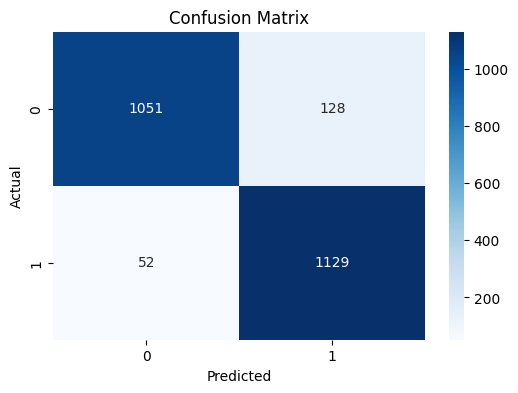

In [166]:
# 使用热图绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [169]:
import pickle
import os

# 保存模型
filename = 'loan_approval_model.pkl'
model_dir = 'model'  # 模型存储目录

# 检查模型存储目录是否存在，如果不存在则创建
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, filename)  # 模型存储路径
pickle.dump(model, open(model_path, 'wb'))

print(f"模型已保存为 {model_path}")

# 保存 scaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
pickle.dump(scaler, open(scaler_path, 'wb'))

print(f"Scaler 已保存为 {scaler_path}")

模型已保存为 model/loan_approval_model.pkl
Scaler 已保存为 model/scaler.pkl
